<a href="https://colab.research.google.com/github/Atellas23/notebooks/blob/main/KernelProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Partition Kernels

## Prerequisites

In [ ]:
import numpy as np
import altair as alt
import pandas as pd

!pip install pipe -q
from pipe import select

from tqdm import tqdm

In [ ]:
image_data = pd.read_csv('./sample_data/mnist_train_small.csv', header=None)
!wget http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.csv -O bodyfat.csv -q
bodyfat = pd.read_csv('./bodyfat.csv')
cols = list(bodyfat)
cols[1], cols[0] = cols[0], cols[1]
bodyfat = bodyfat[cols]

In [ ]:
reduced_mnist = image_data[0:500] # reduced dataset, images in range [0,255]
print(reduced_mnist.shape)

(500, 785)


## Implement the Random Partition Kernel

In [ ]:
class RandomLSHPartitionKernel:
    def __init__(self, data, mink: int, maxk: int):
        self.data = data.iloc[:, 1:].to_numpy()
        self.N = data.shape[0]
        # self.y = data.iloc[:, 0].to_numpy()
        self.mink = mink
        self.maxk = maxk

    def hash(self, image: np.ndarray, h):
        arr = image.flatten()
        s = ''
        for elem in h:
            pix = elem // 256
            num = elem % 256
            s += '1' if num <= arr[pix] else '0'
        return int(s, base=2)

    def generate_partition(self):
        k = np.random.randint(self.mink, self.maxk+1)
        h = np.random.randint(0, 256*784, size=k)
        partition = np.zeros(self.data.shape[0])
        for i, image in enumerate(self.data):
            partition[i] = self.hash(image, h)
        return partition
    
    def kernel_matrix(self, m):
        K = np.zeros((self.N, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition()
            for i in range(self.data.shape[0]):
                for j in range(i, self.data.shape[0]):
                    K[i, j] += int(partition[i] == partition[j])
                    if i != j:
                        K[j, i] += int(partition[i] == partition[j])
        K = K/m
        return K

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
class RandomForestPartitionKernel:
    def __init__(self, data, task='class'):
        self.data = data.iloc[:, 1:].to_numpy(dtype=np.float32)
        self.y = data.iloc[:, 0].to_numpy(dtype=np.float32)
        self.N = data.shape[0]
        self.option = task

    def get_ancestor_label(self, sample, decision_tree, depth):
        x = sample.reshape(1, -1)
        node_indicator = decision_tree.decision_path(x)
        node_index = node_indicator.indices[
            node_indicator.indptr[0] : node_indicator.indptr[1]
        ]
        if depth >= len(node_index):
            return node_index[0]
        else:
            return node_index[-depth-1]

    def generate_partition(self, test_data_x: np.ndarray = None):
        if self.option is 'class':
            RF = RandomForestClassifier(n_estimators=1)
        elif self.option is 'reg':
            RF = RandomForestRegressor(n_estimators=1)
        RF = RF.fit(self.data, self.y)
        T = RF.estimators_[0]
        h = T.get_depth()
        d = np.random.randint(h)
        partition = np.zeros(self.N)
        for i in range(self.N):
            partition[i] = self.get_ancestor_label(self.data[i], T, d)
        
        if test_data_x is not None:
            for j in range(len(test_data_x)):
                partition = np.append(partition, self.get_ancestor_label(test_data_x[j], T, d))
        
        return partition

    def kernel_matrix(self, m):
        K = np.zeros((self.N, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition()
            for i in range(self.data.shape[0]):
                for j in range(i, self.data.shape[0]):
                    K[i, j] += int(partition[i] == partition[j])
                    if i != j:
                        K[j, i] += int(partition[i] == partition[j])
        K = K/m
        return K
    
    def prediction_kernel_matrix(self, m, unknown_data: np.ndarray):
        L = unknown_data.shape[0]
        K = np.zeros((L, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition(test_data_x=unknown_data)
            for j in range(L):
                for i in range(self.N):
                    K[j, i] += int(partition[self.N + j] == partition[i])
        K = K/m
        return K

In [ ]:
!wget https://gist.githubusercontent.com/Atellas23/aff1ff35e0fb94012800ca8d8a731f80/raw/358a2be973e33691e99ddb191c0f00217f76cf60/MarkovDisseminationProcess.py -q -O MarkovDisseminationProcess.py
from MarkovDisseminationProcess import MarkovDisseminationProcess as MDP

class RandomMDPKernel:
    def __init__(self, data):
        self.data = data.iloc[:, 1:].to_numpy()
        self.N = data.shape[0]

    def generate_partition(self, test_data_x: np.ndarray = None):
        proc = MDP(self.data, iterations=10, gamma=-0.5, p=0.99)
        proc.run()
        partition = proc.cluster.copy()
        if test_data_x is not None:
            for data_object in test_data_x:
                closest_cluster = proc.cluster_distances(data_object)[0][0]
                partition = np.append(partition, closest_cluster)
        return partition
    
    def kernel_matrix(self, m):
        K = np.zeros((self.N, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition()
            for i in range(self.data.shape[0]):
                for j in range(i, self.data.shape[0]):
                    K[i, j] += int(partition[i] == partition[j])
                    if i != j:
                        K[j, i] += int(partition[i] == partition[j])
        K = K/m
        return K
    
    def prediction_kernel_matrix(self, m, unknown_data: np.ndarray):
        L = unknown_data.shape[0]
        K = np.zeros((L, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition(test_data_x=unknown_data)
            for j in range(L):
                for i in range(self.N):
                    K[j, i] += int(partition[self.N + j] == partition[i])
        K = K/m
        return K

In [ ]:
class FastClusterKernel:
    def __init__(self, data, h, distance_option='d2'):
        self.data = data.iloc[:, 1:].to_numpy()
        self.N = data.shape[0]
        self.h = h
        self.option = distance_option

    def d2(self, data_object, center, d):
        diff = data_object - self.data[center]
        diff = np.multiply(diff, d)
        return np.sqrt(np.sum(np.square(diff)))
                
    def d1(self, data_object, center, d):
        diff = data_object - self.data[center]
        diff = np.multiply(diff, d)
        return np.sum(np.abs(diff))

    def generate_partition(self, test_data_x: np.ndarray = None):
        d = np.random.binomial(1, 0.5, size=self.data.shape[1])
        s = np.random.randint(self.h)
        c = np.random.randint(self.N, size=np.power(2, s))
        partition = np.zeros(self.N)
        for i, data_object in enumerate(self.data):
            # argmin de les distàncies amb els centres
            if i in c:
                partition[i] = i
            else:
                if self.option is 'd2':
                    partition[i] = sorted([(center, self.d2(data_object, center, d)) for center in c], key=lambda t: t[1])[0][0]
                elif self.option is 'd1':
                    partition[i] = sorted([(center, self.d1(data_object, center, d)) for center in c], key=lambda t: t[1])[0][0]
        if test_data_x is not None:
            for data_object in test_data_x:
                if self.option is 'd2':
                    closest_center = sorted([(center, self.d2(data_object, center, d)) for center in c], key=lambda t: t[1])[0][0]
                if self.option is 'd1':
                    closest_center = sorted([(center, self.d1(data_object, center, d)) for center in c], key=lambda t: t[1])[0][0]
                partition = np.append(partition, closest_center)
        return partition
    
    def kernel_matrix(self, m):
        K = np.zeros((self.N, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition()
            for i in range(self.data.shape[0]):
                for j in range(i, self.data.shape[0]):
                    K[i, j] += int(partition[i] == partition[j])
                    if i != j:
                        K[j, i] += int(partition[i] == partition[j])
        K = K/m
        return K
    
    def prediction_kernel_matrix(self, m, unknown_data: np.ndarray):
        L = unknown_data.shape[0]
        K = np.zeros((L, self.N))
        for iteration in tqdm(range(m)):
            partition = self.generate_partition(test_data_x=unknown_data)
            for j in range(L):
                for i in range(self.N):
                    K[j, i] += int(partition[self.N + j] == partition[i])
        K = K/m
        return K

## Experiments

### KernelPCA

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

#### Bodyfat

##### Linear Benchmark

In [ ]:
X_pca_bodyfat = (
            PCA(2)
            .fit_transform(bodyfat)
        )

pca_bodyfat_df = pd.DataFrame({
    'x': X_pca_bodyfat[:, 0],
    'y': X_pca_bodyfat[:, 1],
    'bodyfat': bodyfat.iloc[:, 0].to_numpy(dtype=np.float32)
})

pca_chart = alt.Chart(pca_bodyfat_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('bodyfat:Q', scale=alt.Scale(scheme='inferno'))
)

display(pca_chart)

alt.Chart(...)

##### Random Forest Kernel

In [ ]:
random_forest_kernel = RandomForestPartitionKernel(bodyfat, task='reg')
random_forest_kernel_matrix = random_forest_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(random_forest_kernel_matrix)
        )

random_forest_kernel_bodyfat_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'bodyfat': bodyfat.iloc[:, 0].to_numpy(dtype=np.float32)
})

random_forest_kernel_bodyfat_chart = alt.Chart(random_forest_kernel_bodyfat_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('bodyfat:Q', scale=alt.Scale(scheme='inferno'))
)

display(random_forest_kernel_bodyfat_chart)

100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


alt.Chart(...)

##### Markov Dissemination Process Kernel

In [ ]:
MDP_kernel = RandomMDPKernel(bodyfat)
MDP_kernel_matrix = MDP_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(MDP_kernel_matrix)
        )

MDP_kernel_bodyfat_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'bodyfat': bodyfat.iloc[:, 0].to_numpy(dtype=np.float32)
})

MDP_kernel_bodyfat_chart = alt.Chart(MDP_kernel_bodyfat_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('bodyfat:Q', scale=alt.Scale(scheme='inferno'))
)

display(MDP_kernel_bodyfat_chart)

100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


alt.Chart(...)

##### Fast Cluster Kernel

In [ ]:
fast_cluster_kernel = FastClusterKernel(bodyfat, 3)
fast_cluster_kernel_matrix = fast_cluster_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(fast_cluster_kernel_matrix)
        )

fast_cluster_kernel_bodyfat_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'bodyfat': bodyfat.iloc[:, 0].to_numpy(dtype=np.float32)
})

fast_cluster_kernel_bodyfat_chart = alt.Chart(fast_cluster_kernel_bodyfat_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('bodyfat:Q', scale=alt.Scale(scheme='inferno'))
)

display(fast_cluster_kernel_bodyfat_chart)

100%|██████████| 200/200 [00:20<00:00,  9.83it/s]


alt.Chart(...)

#### MNIST

##### Linear Benchmark

In [ ]:
X_pca = (
            PCA(2)
            .fit_transform(reduced_mnist)
        )

pca_mnist_df = pd.DataFrame({
    'x': X_pca[:, 0],
    'y': X_pca[:, 1],
    'class': reduced_mnist.iloc[:, 0].to_numpy(dtype=int)
})

pca_chart = alt.Chart(pca_mnist_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='class:N'
)

display(pca_chart)

alt.Chart(...)

##### LSH Kernel

In [ ]:
lsh_kernel = RandomLSHPartitionKernel(reduced_mnist, 5, 10)
lsh_kernel_matrix = lsh_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(lsh_kernel_matrix)
        )

lsh_kernel_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'class': reduced_mnist.iloc[:, 0].to_numpy(dtype=int)
})

lsh_kernel_chart = alt.Chart(lsh_kernel_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='class:N'
)

display(lsh_kernel_chart)

100%|██████████| 200/200 [01:09<00:00,  2.88it/s]


alt.HConcatChart(...)

##### Random Forest Kernel

In [ ]:
random_forest_kernel = RandomForestPartitionKernel(reduced_mnist, task='class')
random_forest_kernel_matrix = random_forest_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(random_forest_kernel_matrix)
        )

random_forest_kernel_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'class': reduced_mnist.iloc[:, 0].to_numpy(dtype=int)
})

random_forest_kernel_chart = alt.Chart(random_forest_kernel_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='class:N'
)

display(random_forest_kernel_chart)

100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


alt.HConcatChart(...)

##### Fast Cluster Kernel

In [ ]:
fast_cluster_kernel = FastClusterKernel(reduced_mnist, 4, distance_option='d1')
fast_cluster_kernel_matrix = fast_cluster_kernel.kernel_matrix(200)

X_kpca = (
            KernelPCA(
                2, kernel="precomputed"
                )
            .fit_transform(fast_cluster_kernel_matrix)
        )

fast_cluster_kernel_df = pd.DataFrame({
    'x': X_kpca[:, 0],
    'y': X_kpca[:, 1],
    'class': reduced_mnist.iloc[:, 0].to_numpy(dtype=int)
})

fast_cluster_kernel_chart = alt.Chart(fast_cluster_kernel_df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color='class:N'
)

display(fast_cluster_kernel_chart)

100%|██████████| 200/200 [01:15<00:00,  2.67it/s]


alt.HConcatChart(...)

### KernelSVM

In [ ]:
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Bodyfat

In [ ]:
mse_predictors = []

##### Linear Benchmark

In [ ]:
linear_regressor = LinearSVR()

# Split data into 80% train and 20% test subsets
X_train, X_test = train_test_split(bodyfat, test_size=0.2)

y_train = X_train.iloc[:, 0].to_numpy(dtype=np.float32)
X_train = X_train.iloc[:, 1:].to_numpy(dtype=np.float32)
y_test = X_test.iloc[:, 0].to_numpy(dtype=np.float32)
X_test = X_test.iloc[:, 1:].to_numpy(dtype=np.float32)


linear_regressor.fit(X_train, y_train)
predicted = linear_regressor.predict(X_test)
print(predicted)

linear_regressor_mse = metrics.mean_squared_error(y_test, predicted)
mse_predictors.append(linear_regressor_mse)
print('mse:', linear_regressor_mse)

[18.53302042 36.72723536 12.82871845 17.31422819 29.16196165 21.21229667
 23.17099357 17.44647769 30.25458931 19.73362289 18.784616   16.42143272
 39.3712129  32.4489201  17.43366599 23.00941208 26.44715387 18.18300927
 20.25939808 11.3917726  15.63484841  9.85026793 21.1815548  18.57411323
 26.79564845 29.42456869 20.11940673 14.14598687 18.77519808 20.83857905
 16.30900621 18.99094483 12.52461495 14.56572951 14.15930102 25.26998446
 25.92376746 22.71298726 37.7368913  22.19361256 23.0300662  20.16787885
  7.89190898 43.17086044 23.76255268 34.38975669 20.82717055 21.88436892
 30.25393372 17.76730253 12.88212175]
mse: 29.53635858375049


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


##### Random Forest Kernel

In [ ]:
regressor = SVR(kernel='precomputed')

# Split data into 80% train and 20% test subsets
X_train, X_test = train_test_split(bodyfat, test_size=0.2)

random_forest_kernel_train = RandomForestPartitionKernel(X_train, task='reg')
random_forest_kernel_matrix_train = random_forest_kernel_train.kernel_matrix(200)
print(random_forest_kernel_matrix_train.shape)

random_forest_kernel_matrix_test = random_forest_kernel_train.prediction_kernel_matrix(200, X_test.iloc[:, 1:].to_numpy(dtype=np.float32))
print(random_forest_kernel_matrix_test.shape)

regressor.fit(random_forest_kernel_matrix_train, X_train.iloc[:, 0].to_numpy(dtype=np.float32))
predicted = regressor.predict(random_forest_kernel_matrix_test)
# print(predicted)

y_test = X_test.iloc[:, 0].to_numpy(dtype=np.float32)

random_forest_regressor_mse = metrics.mean_squared_error(y_test, predicted)
mse_predictors.append(random_forest_regressor_mse)
print('mse:', random_forest_regressor_mse)

100%|██████████| 200/200 [00:18<00:00, 10.68it/s]


(201, 201)


100%|██████████| 200/200 [00:12<00:00, 15.75it/s]

(51, 201)
mse: 18.62347432940883


##### MDP Kernel

In [ ]:
regressor = SVR(kernel='precomputed')

# Split data into 80% train and 20% test subsets
X_train, X_test = train_test_split(bodyfat, test_size=0.2)

MDP_kernel_train = RandomMDPKernel(X_train)
MDP_kernel_matrix_train = MDP_kernel_train.kernel_matrix(200)
print(MDP_kernel_matrix_train.shape)

MDP_kernel_matrix_test = MDP_kernel_train.prediction_kernel_matrix(200, X_test.iloc[:, 1:].to_numpy(dtype=np.float32))
print(MDP_kernel_matrix_test.shape)

regressor.fit(MDP_kernel_matrix_train, X_train.iloc[:, 0].to_numpy(dtype=np.float32))
predicted = regressor.predict(MDP_kernel_matrix_test)
# print(predicted)

y_test = X_test.iloc[:, 0].to_numpy(dtype=np.float32)

MDP_regressor_mse = metrics.mean_squared_error(y_test, predicted)
mse_predictors.append(MDP_regressor_mse)
print('mse:', MDP_regressor_mse)

100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


(201, 201)


100%|██████████| 200/200 [02:12<00:00,  1.51it/s]

(51, 201)
mse: 34.53471419818869


##### Fast Cluster Kernel

In [ ]:
regressor = SVR(kernel='precomputed')

# Split data into 80% train and 20% test subsets
X_train, X_test = train_test_split(bodyfat, test_size=0.2)

fast_cluster_kernel_train = FastClusterKernel(X_train, 3)
fast_cluster_kernel_matrix_train = fast_cluster_kernel_train.kernel_matrix(200)
print(fast_cluster_kernel_matrix_train.shape)

fast_cluster_kernel_matrix_test = fast_cluster_kernel_train.prediction_kernel_matrix(200, X_test.iloc[:, 1:].to_numpy(dtype=np.float32))
print(fast_cluster_kernel_matrix_test.shape)

regressor.fit(fast_cluster_kernel_matrix_train, X_train.iloc[:, 0].to_numpy(dtype=np.float32))
predicted = regressor.predict(fast_cluster_kernel_matrix_test)
# print(predicted)

y_test = X_test.iloc[:, 0].to_numpy(dtype=np.float32)
fast_cluster_regressor_mse = metrics.mean_squared_error(y_test, predicted)
mse_predictors.append(fast_cluster_regressor_mse)
print('mse:', fast_cluster_regressor_mse)

100%|██████████| 200/200 [00:13<00:00, 15.15it/s]


(201, 201)


100%|██████████| 200/200 [00:05<00:00, 37.43it/s]

(51, 201)
mse: 39.12134672215812


##### Visualization

In [ ]:
mse_df = pd.DataFrame({
    'Kernel': ['Linear', 'Random Forest', 'MDP', 'FastCluster'],
    'MSE': mse_predictors
})
mse_viz = alt.Chart(mse_df).mark_bar().encode(
    x='Kernel:N',
    y='MSE:Q',
    color=alt.Color('Kernel:N', legend=None)
).properties(width=800)

In [ ]:
display(mse_viz)

alt.Chart(...)

#### MNIST

In [ ]:
precision_predictors = []

##### Linear Benchmark

Weighted average of metrics: {'precision': 0.7831766566766565, 'recall': 0.77, 'f1-score': 0.7646474474180492, 'support': 100}


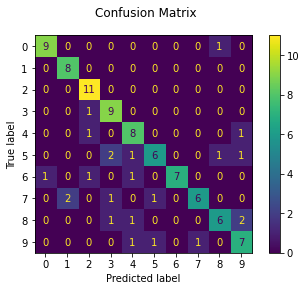

In [ ]:
linear_classifier = LinearSVC()

# Split data into 80% train and 20% test subsets
train_indices, test_indices = train_test_split(list(range(reduced_mnist.shape[0])), test_size=0.2)

X_train = reduced_mnist.iloc[train_indices, 1:].to_numpy(dtype=int)
y_train = reduced_mnist.iloc[train_indices, 0].to_numpy(dtype=int)
X_test = reduced_mnist.iloc[test_indices, 1:].to_numpy(dtype=int)
y_test = reduced_mnist.iloc[test_indices, 0].to_numpy(dtype=int)


linear_classifier.fit(X_train, y_train)
predicted = linear_classifier.predict(X_test)
# print(predicted)

linear_metric_dict = metrics.classification_report(y_test, predicted, output_dict=True)

print('Weighted average of metrics:', linear_metric_dict['weighted avg'])
precision_predictors.append(linear_metric_dict['weighted avg']['precision'])


import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

##### LSH Kernel

100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


Weighted average of metrics: {'precision': 0.8533449050949051, 'recall': 0.83, 'f1-score': 0.8299480069072598, 'support': 100}


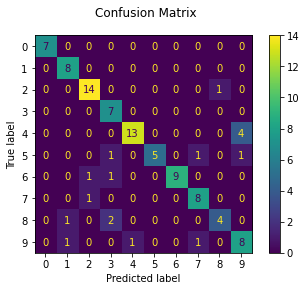

In [ ]:
classifier = SVC(kernel='precomputed')

# Split data into 80% train and 20% test subsets
train_indices, test_indices = train_test_split(list(range(reduced_mnist.shape[0])), test_size=0.2)

lsh_kernel = RandomLSHPartitionKernel(reduced_mnist, 5, 10)
lsh_kernel_matrix = lsh_kernel.kernel_matrix(200)
# print(lsh_kernel_matrix.shape)

lsh_kernel_matrix_test = lsh_kernel_matrix[test_indices, :][:, train_indices]
lsh_kernel_matrix_train = lsh_kernel_matrix[train_indices, :][:, train_indices]
# print('test shape:', lsh_kernel_matrix_test.shape)
# print('train shape:', lsh_kernel_matrix_train.shape)

classifier.fit(lsh_kernel_matrix_train, reduced_mnist.iloc[train_indices, 0].to_numpy(dtype=int))
predicted = classifier.predict(lsh_kernel_matrix_test)
# print(predicted)

y_test = reduced_mnist.iloc[test_indices, 0].to_numpy(dtype=int)
lsh_metric_dict = metrics.classification_report(y_test, predicted, output_dict=True)

print('Weighted average of metrics:', lsh_metric_dict['weighted avg'])
precision_predictors.append(lsh_metric_dict['weighted avg']['precision'])

import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

##### Random Forest Kernel

100%|██████████| 200/200 [00:30<00:00,  6.48it/s]


Weighted average of metrics: {'precision': 0.8362870945479641, 'recall': 0.82, 'f1-score': 0.8164295599481357, 'support': 100}


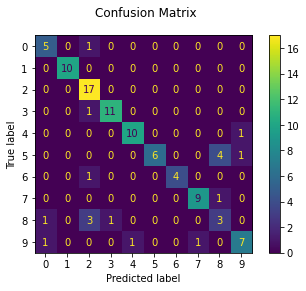

In [ ]:
classifier = SVC(kernel='precomputed')

# Split data into 80% train and 20% test subsets
train_indices, test_indices = train_test_split(list(range(reduced_mnist.shape[0])), test_size=0.2)

train_data = reduced_mnist.iloc[train_indices, :]
y_train = reduced_mnist.iloc[train_indices, 0].to_numpy(dtype=int)

X_test = reduced_mnist.iloc[test_indices, 1:].to_numpy(dtype=int)
y_test = reduced_mnist.iloc[test_indices, 0].to_numpy(dtype=int)

random_forest_kernel = RandomForestPartitionKernel(train_data, task='class')
random_forest_kernel_matrix_train = random_forest_kernel.kernel_matrix(200)
# print('train shape:', random_forest_kernel_matrix_train.shape)

classifier.fit(random_forest_kernel_matrix_train, y_train)

random_forest_kernel_matrix_test = random_forest_kernel.prediction_kernel_matrix(200, X_test)
# print('test shape:', random_forest_kernel_matrix_test.shape)

predicted = classifier.predict(random_forest_kernel_matrix_test)
# print(predicted)

random_forest_metric_dict = metrics.classification_report(y_test, predicted, output_dict=True)

print('Weighted average of metrics:', random_forest_metric_dict['weighted avg'])
precision_predictors.append(random_forest_metric_dict['weighted avg']['precision'])

import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

##### Fast Cluster Kernel

100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


Weighted average of metrics: {'precision': 0.7890151515151516, 'recall': 0.73, 'f1-score': 0.7363613201802459, 'support': 100}


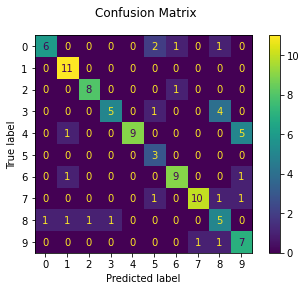

In [ ]:
classifier = SVC(kernel='precomputed')

# Split data into 80% train and 20% test subsets
train_indices, test_indices = train_test_split(list(range(reduced_mnist.shape[0])), test_size=0.2)

train_data = reduced_mnist.iloc[train_indices, :]
y_train = reduced_mnist.iloc[train_indices, 0].to_numpy(dtype=int)

X_test = reduced_mnist.iloc[test_indices, 1:].to_numpy(dtype=int)
y_test = reduced_mnist.iloc[test_indices, 0].to_numpy(dtype=int)

fast_cluster_kernel = FastClusterKernel(train_data, 3)
fast_cluster_kernel_matrix_train = fast_cluster_kernel.kernel_matrix(200)
# print('train shape:', fast_cluster_kernel_matrix_train.shape)

classifier.fit(fast_cluster_kernel_matrix_train, y_train)

fast_cluster_kernel_matrix_test = fast_cluster_kernel.prediction_kernel_matrix(200, X_test)
# print('test shape:', fast_cluster_kernel_matrix_test.shape)

predicted = classifier.predict(fast_cluster_kernel_matrix_test)
# print(predicted)

fast_cluster_metric_dict = metrics.classification_report(y_test, predicted, output_dict=True)

print('Weighted average of metrics:', fast_cluster_metric_dict['weighted avg'])
precision_predictors.append(fast_cluster_metric_dict['weighted avg']['precision'])

import matplotlib.pyplot as plt
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

##### Visualization

In [ ]:
precision_df = pd.DataFrame({
    'Kernel': ['Linear', 'LSH', 'Random Forest', 'Fast Cluster'],
    'Precision': precision_predictors
})

precision_viz = alt.Chart(precision_df).mark_bar().encode(
    x='Kernel:N',
    y='Precision:Q',
    color=alt.Color('Kernel:N', legend=None)
).properties(width=800)

In [ ]:
display(precision_viz)

alt.Chart(...)